# Fashion-MNIST Notebook
In this notebook we will try to classify different fashion items and clothes based on black-and-white pictures from the "fashion mnist" dataset without using neural networks.


Importing libraries and data:

In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.datasets import fashion_mnist #dataset

In [2]:
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data() #dataset split
X_train.shape

(60000, 28, 28)

## Data Preparations

The dataset is an educational dataset, therefore the data is clean and useable (only simple scaling is required)

Example picture from the dataset:

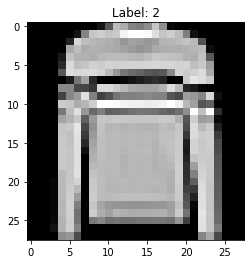

In [3]:
import matplotlib.pyplot as plt
example_img=X_train[5]
plt.imshow(example_img, cmap="gray")
plt.title('Label: '+str(y_train[5]))
plt.show()

## Labels legend:
0- T-shirt/top  
1- Trouser  
2- Pullover  
3- Dress  
4- Coat  
5- Sandal  
6- Shirt  
7- Sneaker  
8- Bag  
9- Ankle boot

In [4]:
labels=['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']

The picture in the example (picture no. 5) represents a Pullover.

In [5]:
# test dataset size 
y_test.size

10000

Each picture has 28*28 pixels, 784 dimensions to the data.  
It's very hard to handle and not very effective because there are some pixels who are similar for all pictures (for example the pixels at the corners).

We will combat this problem in two ways, the first will be a limited decision tree.  
The tree will choose the most relevant dimensions to divide the data by.

The second solution will be dimensional reduction using PCA, with this method we will not only choose the most useful dimensions but also create new dimenstions that will represent combinations of multiple dimensions, compressing more data to the same number of dimensions.

In [6]:
#making sure data is not distorted
print ('max pixel value: ' + str(X_train.max()))
print ('min pixel value: '+ str(X_train.min()))
print ('mean pixel value: '+ str(X_train.mean()))

max pixel value: 255
min pixel value: 0
mean pixel value: 72.94035223214286


In [7]:
#scaling
X_train_sc=X_train/255
print('after scaling:')
print ('max pixel value: ' + str(X_train_sc.max()))
print ('min pixel value: '+ str(X_train_sc.min()))
print ('mean pixel value: '+ str(X_train_sc.mean()))

after scaling:
max pixel value: 1.0
min pixel value: 0.0
mean pixel value: 0.2860405969887955


Text(0.5, 1.0, 'frequency of labels')

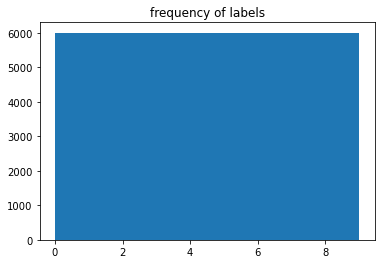

In [8]:
#samples distribution
plt.hist(y_train)
plt.title('frequency of labels')

Equal representation for all labels.
The dataset is balanced, so good scores will translate well to the test set and real-life scenarios.

Reshaping the dataset to fit the classifiers:

In [9]:
X_train_sc=X_train_sc.reshape((60000,784))
X_train_sc.shape

(60000, 784)

Scaling and reshaping the test set:

In [10]:
X_test_sc=X_test/255
X_test_sc=X_test_sc.reshape((10000,784))
print('test set shape: '+str(X_test_sc.shape))
print('test set max:'+ str(X_test_sc.max()))

test set shape: (10000, 784)
test set max:1.0


## Decision Tree

Scoring method: in multiclass classifications there are several scoring methods.  
The method I will use is accuracy, we will try to classify as many cases as possible.  
The data is balanced, so good accuracy = good performance.

In [11]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
dtc=DecisionTreeClassifier(random_state=0, max_depth=10)
dtc.fit(X_train_sc, y_train)
dtc_pred1 = dtc.predict(X_train_sc)
print ('train set accuracy: '+str(accuracy_score(y_train,dtc_pred1)))

train set accuracy: 0.8514833333333334


The results look fine, we will try to improve the performance with grid search on the tree hight.

In [12]:
from sklearn.model_selection import GridSearchCV
depths={'max_depth':[5,10,15,20]}
grid=GridSearchCV(dtc,depths,scoring='accuracy',cv=5)
grid.fit(X_train_sc,y_train)

GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(max_depth=10, random_state=0),
             param_grid={'max_depth': [5, 10, 15, 20]}, scoring='accuracy')

In [13]:
#plotting the results
pd.DataFrame(grid.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,7.522592,0.048070,0.034912,0.001108,5,{'max_depth': 5},0.705917,0.703167,0.709583,0.71200,0.708417,0.707817,0.003040,4
1,15.088974,0.428989,0.034500,0.000477,10,{'max_depth': 10},0.805917,0.802917,0.808333,0.81050,0.809667,0.807467,0.002753,2
2,20.744712,0.206200,0.035284,0.001017,15,{'max_depth': 15},0.811667,0.807750,0.814750,0.81775,0.813000,0.812983,0.003316,1
3,24.694383,0.139873,0.036642,0.001335,20,{'max_depth': 20},0.798333,0.802083,0.803000,0.80975,0.806250,0.803883,0.003869,3


<AxesSubplot:xlabel='param_max_depth', ylabel='mean test score'>

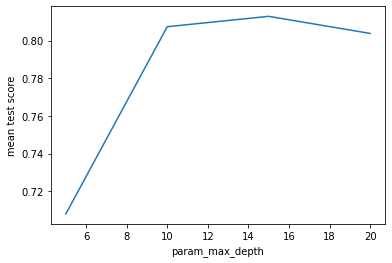

In [14]:
d_compare=pd.DataFrame(grid.cv_results_)[['mean_test_score','param_max_depth']]
d_compare.plot(y='mean_test_score',x='param_max_depth',legend=False,ylabel='mean test score')

the graph peaks at max_depth=15, so we will use this parameter in the final evaluation on the test set.

In [15]:
dtc=grid.best_estimator_
dtc_pred=dtc.predict(X_test_sc)
dtc_pred

array([9, 6, 1, ..., 8, 1, 5], dtype=uint8)

In [16]:
#test score
print('decision tree test accuracy: '+str(accuracy_score(y_test,dtc_pred)))

decision tree test accuracy: 0.8072


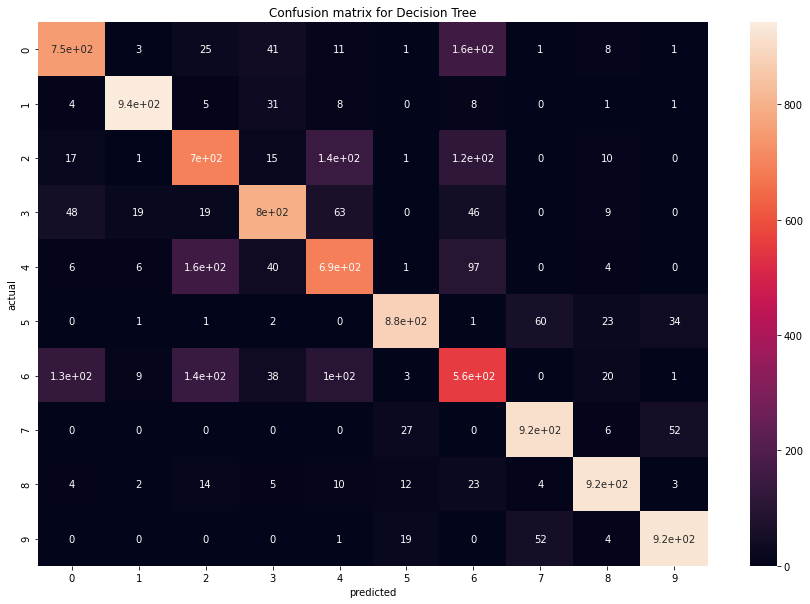

In [17]:
#confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
plt.figure(figsize=(15,10))
sns.heatmap(confusion_matrix(y_test,dtc_pred),annot=True)
plt.xlabel('predicted')
plt.ylabel('actual')
plt.title('Confusion matrix for Decision Tree')
plt.show()

The best classified label is 1 (Trouser), The most confused labels are 2 and 4 (Pullover and Coat) which is understandable.  
Another common mistakes: 0 and 6 (T-shirt/top and Shirt)  
                         2 and 6 (Pullover and Shirt)  
                         4 and 6 (Coat and Shirt)  
The classifier had the most mistakes with label 6 (Shirt).

## Random Forest

We will try to improve the previus attempt by implementing this ensemble-learning algorithem that is based on decision trees.  
We will limit the trees to maximum depth of 15 and play with the number of trees.  


In [18]:
from sklearn.ensemble import RandomForestClassifier
rfc=RandomForestClassifier(max_depth=15, random_state=0)
rfc.fit(X_train_sc,y_train)

RandomForestClassifier(max_depth=15, random_state=0)

The default number of trees is 100.

In [19]:
rfc.score(X_train_sc,y_train)

0.9642

Initial score looks good, now we will try to improve it.

In [20]:
grid=GridSearchCV(rfc,{'n_estimators':[60,80,100,120,140]},cv=3,scoring='accuracy')
grid.fit(X_train_sc,y_train)

GridSearchCV(cv=3,
             estimator=RandomForestClassifier(max_depth=15, random_state=0),
             param_grid={'n_estimators': [60, 80, 100, 120, 140]},
             scoring='accuracy')

<AxesSubplot:xlabel='param_n_estimators', ylabel='mean test score'>

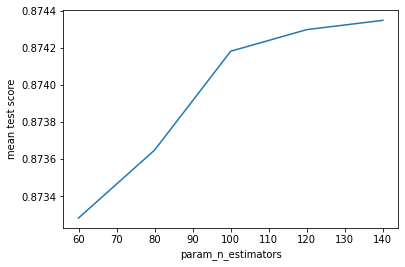

In [21]:
n_compare=pd.DataFrame(grid.cv_results_)[['mean_test_score','param_n_estimators']]
n_compare.plot(y='mean_test_score',x='param_n_estimators',legend=False,ylabel='mean test score')

In [22]:
grid=GridSearchCV(rfc,{'n_estimators':[140,160,180,200]},cv=3,scoring='accuracy')
grid.fit(X_train_sc,y_train)

KeyboardInterrupt: 

In [ ]:
n_compare=pd.DataFrame(grid.cv_results_)[['mean_test_score','param_n_estimators']]
n_compare.plot(y='mean_test_score',x='param_n_estimators',legend=False,ylabel='mean test score')

Further improvement is not worth the computing power, we will leave the estimator at 200 trees.

### Random forest results

In [ ]:
#test score
rfc=grid.best_estimator_
rfc_pred=rfc.predict(X_test_sc)
print ('Random forest accuracy: '+str(accuracy_score(y_test,rfc_pred)))

The accuracy is much better than 0.803 from the Decision tree.

In [ ]:
#confusion matrix
plt.figure(figsize=(15,10))
sns.heatmap(confusion_matrix(y_test,rfc_pred),annot=True)
plt.xlabel('predicted')
plt.ylabel('actual')
plt.title('Confusion matrix for Random Forest')
plt.show()

Many mistakes were corrected, but number of 6 (Shirt) classified as 0 (T-shirt/top) increased.

## PCA

Before moving to another ensemble-learning algorithm we will reduce the dimensions of the problem.  
To do so we will use the PCA (Principal Component Analysis) method.  
Using this method we can decide how much of the variance in the data we want to keep and the algorithm will choose/create the parameters that will satisfy our need with minimal dimensions count.  
For further read visit: https://en.wikipedia.org/wiki/Principal_component_analysis

In [23]:
from sklearn.decomposition import PCA
pca=PCA(n_components=0.9,svd_solver='auto',random_state=42)
X_reduce=pca.fit_transform(X_train_sc)
X_reduce.shape

(60000, 84)

applying same reduction to the test set:

In [33]:
X_test_red=pca.transform(X_test_sc)
X_test_red.shape

(10000, 84)

We reduced the number of dimentions to 84 (from 784) whie keeping 90% of the variance.
Let's compare decision tree on the full data versus on the reduced data.

In [25]:
dtc.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 15,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': 'deprecated',
 'random_state': 0,
 'splitter': 'best'}

In [37]:
dtc.fit(X_train_sc,y_train)

DecisionTreeClassifier(max_depth=15, random_state=0)

In [38]:
print('accuracy without PCA: '+str(dtc.score(X_test_sc,y_test)))

accuracy without PCA: 0.8072


In [39]:
dtc.fit(X_reduce,y_train)

DecisionTreeClassifier(max_depth=15, random_state=0)

In [40]:
print('accuracy with PCA: '+str(dtc.score(X_test_red,y_test)))

accuracy with PCA: 0.7793


Measuring execution times for both classifiers:

In [47]:
%%time
dtc.fit(X_train_sc,y_train)

Wall time: 22.6 s


DecisionTreeClassifier(max_depth=15, random_state=0)

In [48]:
%%time
dtc.fit(X_reduce,y_train)

Wall time: 7.37 s


DecisionTreeClassifier(max_depth=15, random_state=0)

The reduced data took only 1/3 of the time for only 0.03 reduced accuracy.